In [ ]:
!pip install transformers
!pip install datasets
!pip install sentencepiece
!pip install opendatasets
!pip install git+https://github.com/nficano/pytube.git
!pip install imageio-ffmpeg

In [ ]:
import pandas as pd
import opendatasets as od

od.download("https://www.kaggle.com/datasets/rajatrc1705/youtube-videos-dataset")
data=pd.read_csv('/content/youtube-videos-dataset/youtube.csv')
data

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: vorobevaleksandr
Your Kaggle Key: ··········


100%|██████████| 646k/646k [00:00<00:00, 90.6MB/s]

,link,title,description,category
0,JLZlCZ0,Ep 1| Travelling through North East India | Of...,Tanya Khanijow\n671K subscribers\nSUBSCRIBE\nT...,travel
1,i9E_Blai8vk,Welcome to Bali | Travel Vlog | Priscilla Lee,Priscilla Lee\n45.6K subscribers\nSUBSCRIBE\n*...,travel
2,r284c-q8oY,My Solo Trip to ALASKA | Cruising From Vancouv...,Allison Anderson\n588K subscribers\nSUBSCRIBE\...,travel
3,Qmi-Xwq-ME,Traveling to the Happiest Country in the World!!,Yes Theory\n6.65M subscribers\nSUBSCRIBE\n*BLA...,travel
4,_lcOX55Ef70,Solo in Paro Bhutan | Tiger's Nest visit | Bhu...,Tanya Khanijow\n671K subscribers\nSUBSCRIBE\nH...,travel
...,...,...,...,...
3594,#NAME?,21st Century Challenges: Crash Course European...,CrashCourse\n12.4M subscribers\nSUBSCRIBE\nThe...,history
3595,d-2Trw8bCa0,EU DataViz webinar - Barnaby Skinner - How to ...,Publications Office of the European Union\n3.2...,history
3596,RCKWarkUL,Stone Age Scandinavia: First People In the Nor...,History Time\n619K subscribers\nSUBSCRIBE\n- W...,history
3597,MF6F3BxJIY,AP European History - Interwar Period: Paris P...,Mr. Raymond's Civics and Social Studies Academ...,history


In [ ]:
import torch
from transformers import Speech2TextModel, Speech2TextFeatureExtractor

model = Speech2TextModel.from_pretrained("facebook/s2t-small-librispeech-asr")
feature_extractor = Speech2TextFeatureExtractor.from_pretrained("facebook/s2t-small-librispeech-asr")

Downloading:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/118M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/s2t-small-librispeech-asr were not used when initializing Speech2TextModel: ['lm_head.weight']
- This IS expected if you are initializing Speech2TextModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Speech2TextModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Speech2TextModel were not initialized from the model checkpoint at facebook/s2t-small-librispeech-asr and are newly initialized: ['model.encoder.embed_positions.weights', 'model.decoder.embed_positions.weights']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/242 [00:00<?, ?B/s]

In [ ]:
from pytube import YouTube
import os
from tqdm import tqdm
from moviepy.video.io.VideoFileClip import VideoFileClip
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

def get_embeddings_from_audio(ind_start, ind_end):
  for i in tqdm(range(ind_start, ind_end)):
      link = 'http://youtube.com/watch?v=' + data['link'][i]
      try:
          yt = YouTube(link)
          try:
            if int(yt.length) > 1200:
                print("so long file : " + str(yt.length))
                continue
          except:
            pass
          yt.streams.filter(file_extension="3gpp").order_by('resolution')[-1].download("videos")
          title = data['title'][i].replace("|", "")
          title = title.replace("'", "")
          title = title.replace(":", "")
          title = title.replace(".", "")
          title = title.replace(",", "")
          title = title.replace("/", "")
          title = title.replace("?", "")
          title = title.replace("*", "")
          title = title.replace("#", "")
          title = title.replace("\"", "")
          video_path = "/content/videos/" + title + ".3gpp"

          videoclip = VideoFileClip(video_path)
          audioclip = videoclip.audio
          audio_array = audioclip.to_soundarray().transpose()[0]
          audio_array = audio_array[:min(len(audio_array), 100000)]

          inputs = feature_extractor(audio_array, sampling_rate=16000, return_tensors="pt")
          input_features = inputs.input_features
          decoder_input_ids = torch.tensor([[1, 1]]) * model.config.decoder_start_token_id
          last_hidden_state = model(input_features, decoder_input_ids=decoder_input_ids).last_hidden_state

          adio_emb = torch.cat((last_hidden_state[0][0], last_hidden_state[0][1]), 0)
          df = pd.DataFrame(adio_emb.detach().numpy()).transpose()
          df['target'] = data['category'][i]
          df.to_csv('dataset_embs.csv', mode='a', index=False, header=False)
          os.remove(video_path)
      except Exception as e:
          print(e)
          pass

get_embeddings_from_audio(0, len(data))

In [ ]:
import os
import pandas as pd

l = []
for f in os.listdir():
  if f.endswith('.csv'):
    l.append(pd.read_csv(f, header=None))
df = pd.concat(l)
df.rename(columns = {512:'y'}, inplace=True)
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.to_csv("all_ambs.csv", index=False)
df

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,y
0,-2.291527,-1.005303,-1.574286,8.766344,1.444359,-0.903318,3.391435,-2.225569,0.044628,1.673811,...,2.257302,0.906693,-0.009190,-0.456090,5.692514,-2.114597,-3.013937,3.563913,0.053951,art_music
1,-4.857602,5.667234,-0.440697,7.850719,-7.656270,-0.780946,4.282120,-0.805732,8.048693,1.028108,...,-5.753963,3.354218,0.430656,0.323920,4.589492,2.207919,-1.497469,-2.946845,0.228372,history
2,-1.275124,3.675232,6.241578,3.292589,1.993457,-4.273795,1.652739,0.745637,1.684671,4.252510,...,2.145507,1.751471,0.403878,-1.827422,2.461131,-2.960049,1.594066,1.686965,0.070820,history
3,-1.502043,3.337241,-0.536844,5.809113,1.072140,-0.828517,3.413555,1.373231,-1.038774,3.181847,...,-3.410955,3.156316,-0.845584,-3.048998,0.841970,-1.935450,-1.000842,2.757230,-2.503934,history
4,-2.621759,5.404267,1.343510,5.704121,0.999280,-2.765411,3.296980,-0.137537,4.626804,1.314574,...,-5.044882,2.239849,0.213864,-2.523639,2.309874,-0.384416,1.371369,2.264517,0.764383,history
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119,-2.421922,3.636624,-1.399890,2.976965,-2.254865,-0.943888,4.230135,1.505547,3.225599,1.278587,...,-3.305711,-0.325308,5.431398,-4.636292,3.170339,0.350959,-0.516654,-0.637328,1.372764,travel
1120,1.439415,2.617395,0.596548,5.105431,2.213033,-2.210317,0.208307,0.850221,-2.219842,3.704643,...,0.207987,-0.057068,-2.120710,-1.840198,1.606599,-0.522509,2.198306,-1.250985,-1.159196,travel
1121,-0.602364,1.001871,6.255036,2.262050,2.720320,-0.779891,2.221871,-0.126256,0.762010,-0.683867,...,3.292685,-1.407183,1.326173,-2.213526,4.903532,2.624631,5.622882,4.660527,1.471887,travel
1122,0.938179,1.282327,3.176291,3.048246,0.996862,-1.700804,-0.968351,0.282364,-0.357794,1.569463,...,1.730160,1.282306,-1.162400,-3.361482,0.896663,1.693134,1.238768,-1.625295,1.749098,travel


In [4]:
import pandas as pd

df = pd.read_csv("all_ambs.csv")
df

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,y
0,-2.291527,-1.005303,-1.574286,8.766344,1.444359,-0.903318,3.391435,-2.225569,0.044628,1.673811,...,2.257302,0.906693,-0.009190,-0.456090,5.692514,-2.114597,-3.013937,3.563913,0.053951,art_music
1,-4.857602,5.667234,-0.440697,7.850719,-7.656270,-0.780946,4.282120,-0.805732,8.048693,1.028108,...,-5.753963,3.354218,0.430656,0.323920,4.589492,2.207919,-1.497469,-2.946845,0.228372,history
2,-1.275124,3.675232,6.241578,3.292589,1.993457,-4.273795,1.652739,0.745637,1.684671,4.252510,...,2.145507,1.751471,0.403878,-1.827422,2.461131,-2.960049,1.594066,1.686965,0.070820,history
3,-1.502043,3.337241,-0.536844,5.809113,1.072140,-0.828517,3.413555,1.373231,-1.038774,3.181847,...,-3.410955,3.156316,-0.845584,-3.048998,0.841970,-1.935450,-1.000842,2.757230,-2.503934,history
4,-2.621759,5.404267,1.343510,5.704121,0.999280,-2.765411,3.296980,-0.137537,4.626804,1.314574,...,-5.044882,2.239849,0.213864,-2.523639,2.309874,-0.384416,1.371369,2.264517,0.764383,history
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119,-2.421922,3.636624,-1.399890,2.976965,-2.254865,-0.943888,4.230135,1.505547,3.225599,1.278587,...,-3.305711,-0.325308,5.431398,-4.636292,3.170339,0.350959,-0.516654,-0.637328,1.372764,travel
1120,1.439415,2.617395,0.596548,5.105431,2.213033,-2.210317,0.208307,0.850221,-2.219842,3.704643,...,0.207987,-0.057068,-2.120710,-1.840198,1.606599,-0.522509,2.198306,-1.250985,-1.159196,travel
1121,-0.602364,1.001871,6.255036,2.262050,2.720320,-0.779891,2.221871,-0.126256,0.762010,-0.683867,...,3.292685,-1.407183,1.326173,-2.213526,4.903532,2.624631,5.622882,4.660527,1.471887,travel
1122,0.938179,1.282327,3.176291,3.048246,0.996862,-1.700804,-0.968351,0.282364,-0.357794,1.569463,...,1.730160,1.282306,-1.162400,-3.361482,0.896663,1.693134,1.238768,-1.625295,1.749098,travel


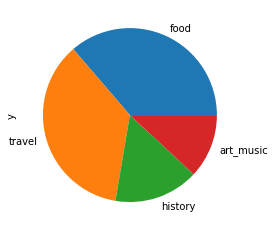

In [5]:
df.y.value_counts().plot.pie()

In [8]:
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
  def __init__(self, x, y):
    self.x_train=torch.tensor(x,dtype=torch.float32)
    self.y_train=torch.tensor(y,dtype=torch.float32).type(torch.LongTensor)
 
  def __len__(self):
    return len(self.y_train)
   
  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]

y = list(df['y'].replace(['food', 'art_music', 'travel', 'history'],
                        [0, 1, 2, 3]))
X = df.drop(['y'], axis=1).values.tolist()

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.1)
trainloader = DataLoader(MyDataset(train_x, train_y), batch_size=32, shuffle=True)
testloader = DataLoader(MyDataset(test_x, test_y), batch_size=32) 
len(train_x), len(test_x)

(1011, 113)

In [60]:
import torch.nn as nn

class SimpleClassifier(nn.Module):
  def __init__(self, embedding_size, num_classes):
    super().__init__()
    self.classifier = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(128, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes),
      )

  def forward(self, x):
    return self.classifier(x)

device = "cuda:0"
clf = SimpleClassifier(embedding_size=512, num_classes=4).to(device)

In [61]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(clf.parameters(), lr=1e-3)  

epochs = 1001
for epoch in range(epochs):
  running_loss = 0.0
  for data in trainloader:
    inputs, labels = [t.to(device) for t in data]
    optimizer.zero_grad()
    outputs = clf(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  if epoch % 100 == 0:
    print(f'[{epoch + 1}] loss: {running_loss / len(trainloader):.5f}')


[1] loss: 1.28493
[101] loss: 0.03589
[201] loss: 0.02219
[301] loss: 0.04955
[401] loss: 0.01482
[501] loss: 0.00801
[601] loss: 0.02668
[701] loss: 0.01637
[801] loss: 0.01698
[901] loss: 0.01724
[1001] loss: 0.01275


In [62]:
clf.eval()
true, pred = [], []
for batch in testloader:
  x, y  = [t.to(device) for t in batch]
  with torch.no_grad():
    logits = clf(x)
    classes = logits.argmax(dim=1)
  
  true.append(y.cpu().numpy())
  pred.append(classes.cpu().numpy())
    
true, pred = np.concatenate(true), np.concatenate(pred)

In [63]:
from sklearn.metrics import f1_score, accuracy_score

print("Accuracy:", accuracy_score(true, pred))
print("F1_score:", f1_score(true, pred, average="weighted"))

Accuracy: 0.5575221238938053
F1_score: 0.5594885226125675
